In [1]:
%matplotlib inline
import os

from PIL import Image
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from tqdm import tqdm
# For repeatability
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)

def save_predicted_image(imamge, path, RESOLUTION):
    predicted_image = imamge.reshape(*RESOLUTION,3).detach().cpu()
    predicted_image = np.array(predicted_image * 255).astype(np.uint8)
    Image.fromarray(predicted_image).save(path)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cuda


# 2D test

In [2]:
RESOLUTION = (512,512)
bounding_box_2d = (torch.tensor([0.0, 0.0]), torch.tensor([1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])

xx, yy= np.meshgrid(x, y)

pts = np.array([xx.reshape(-1), yy.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[:12], 

(tensor([[0.0000, 0.0000],
         [0.0020, 0.0000],
         [0.0039, 0.0000],
         [0.0059, 0.0000],
         [0.0078, 0.0000],
         [0.0098, 0.0000],
         [0.0117, 0.0000],
         [0.0137, 0.0000],
         [0.0157, 0.0000],
         [0.0176, 0.0000],
         [0.0196, 0.0000],
         [0.0215, 0.0000]]),)

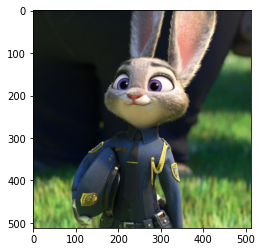

In [3]:
# Load image
img = Image.open('../data/judi.png').resize(RESOLUTION)

plt.imshow(img)
plt.show()

Y = torch.tensor(np.array(img)/255)
Y = Y.reshape(-1,3).float()



## No Encodings

In [4]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    
model = Model().to(device)

In [15]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [17]:
# Results logging folder
results_folder = 'results/2d_xy2color/'
os.makedirs(results_folder, exist_ok=True)

In [18]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    outs = model(pts)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)

    losses+= [loss.item()]
        

100%|██████████| 1000/1000 [00:37<00:00, 26.64it/s]


In [26]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the images directory
os.chdir(results_folder)
# Define the ffmpeg command
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=128:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xy2rgb_animation.gif
os.chdir('../..')

# Compress gif with 
# gifsicle -i ani.gif --lossy=30 --colors 256 -o new_ani.gif

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 0.018236536532640457')

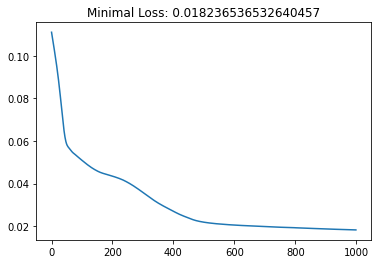

In [24]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

## Freq 2D Encoding

In [5]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


In [6]:
class FreqEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [7]:
freq_encoder = FreqEncoder(
	d_input=2,
	n_freqs=4,
	log_space=False
)


test_x = freq_encoder(pts)
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)
print('Same number of dimations with hash encoding')

torch.Size([262144, 18])
Same number of dimations with hash encoding


In [8]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [9]:
# Results logging folder
results_folder = 'results/2d_xyFreq2color/'
os.makedirs(results_folder, exist_ok=True)

In [10]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    freq_pts = freq_encoder(pts)

    outs = model(freq_pts)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)

    losses+= [loss.item()]
        

100%|██████████| 1000/1000 [00:50<00:00, 19.70it/s]


In [11]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the images directory
os.chdir(results_folder)
# Define the ffmpeg command

# General 
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=128:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xyFreq2rgb_animation.gif
os.chdir('../..')

# !ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=128:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xy2rgb_animation.gif


# If first one doesn't work 
# font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf'
# !ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=256:-1,fps=24,drawtext=text='%{n}':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf':start_number=0:x=10:y=10:fontsize=24:fontcolor=white" ../xyFreq2rgb_animation.gif
# os.chdir('../..')

# Compress gif with 
# gifsicle -i ani.gif --lossy=30 --colors 256 -o new_ani.gif

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 0.00736767565831542')

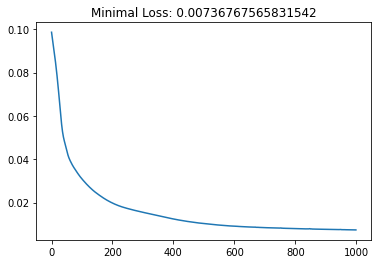

In [12]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

## Encoding 2D Multiresolution Hash

In [35]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights, weights], -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


In [36]:
grid = Grid(
    feature_dim=2, 
    grid_dim=2, 
    num_lvl=8, 
    max_res=1024, 
    min_res=16,
    hashtable_power=19, 
    device=device)

test_out = grid(pts)
print(test_out.shape)
model = Model(test_out.shape[-1]).to(device)


torch.Size([262144, 16])


In [37]:
opt = torch.optim.Adam([
    {'params': grid.parameters()},
    {'params': model.parameters()},
])
crit = nn.MSELoss()

In [38]:
results_folder = 'results/2d_xyHash2color/'
os.makedirs(results_folder, exist_ok=True)

In [39]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)
for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    enc_in = grid(pts)

    outs = model(enc_in)

    loss = crit(outs, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    save_predicted_image(outs, ph, RESOLUTION)
    
    losses+= [loss.item()]
    # for i in range(1000):
        

100%|██████████| 1000/1000 [01:37<00:00, 10.25it/s]


In [40]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the specified directory
os.chdir(results_folder)
# Define the ffmpeg command
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=128:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xyHash2rgb_animation.gif
os.chdir('../..')


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 3.444346020842204e-06')

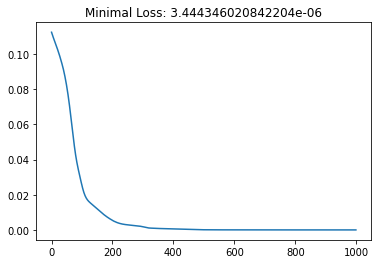

In [41]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

#   
***  
***  
***  

# 3D test

In [2]:
# For Plotting 
def get_3d_image(predictions, RESOLUTION):
    predicted_images = predictions.reshape(*RESOLUTION, 3).cpu().detach()
    total_images = RESOLUTION[2]


    width, height = RESOLUTION[:2]

    # Calculate the total width for the new image
    total_width = width * total_images//2
    total_height= height * 2

    # Create a new blank image with the total width and same height as the individual images
    combined_image = Image.new('RGB', (total_width, total_height))

    k = 0
    for i in range(total_images//2):
        for j in range(2):
            img = predicted_images[:,:,k]
            img = Image.fromarray(np.array(img*255).astype(np.uint8))
            combined_image.paste(img, (i * width, j * height))
            k+=1
    return combined_image

def get_3d_image_height(predictions, RESOLUTION):
    predicted_images = predictions.reshape(*RESOLUTION, 3).cpu().detach()
    total_images = RESOLUTION[2]

    width, height = RESOLUTION[:2]

    # Calculate the total width for the new image
    total_width = width * 2
    total_height= height * total_images//2

    # Create a new blank image with the total width and same height as the individual images
    combined_image = Image.new('RGB', (total_width, total_height))

    k = 0
    for i in range(total_images//2):
        for j in range(2):
            img = predicted_images[:,:,k]
            img = Image.fromarray(np.array(img*255).astype(np.uint8))
            combined_image.paste(img, (j * width, i * height))
            k+=1
    return combined_image

In [3]:
RESOLUTION = [100,100,10]
bounding_box_3d = (torch.tensor([0.0, 0.0, 0.0]), torch.tensor([1.0, 1.0, 1.0]))

x = np.linspace(0,1,RESOLUTION[0])
y = np.linspace(0,1,RESOLUTION[1])
z = np.linspace(0,1,RESOLUTION[2])

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


pts = np.array([xx.reshape(-1), yy.reshape(-1),zz.reshape(-1)]).T
pts = torch.tensor(pts).float()
pts[5:15], pts.shape

(tensor([[0.0000, 0.0000, 0.5556],
         [0.0000, 0.0000, 0.6667],
         [0.0000, 0.0000, 0.7778],
         [0.0000, 0.0000, 0.8889],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0101, 0.0000],
         [0.0000, 0.0101, 0.1111],
         [0.0000, 0.0101, 0.2222],
         [0.0000, 0.0101, 0.3333],
         [0.0000, 0.0101, 0.4444]]),
 torch.Size([100000, 3]))

In [4]:
pts.min(0)[0], pts.max(0)[0]

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [5]:
path = '../data/frames'

images = []
display_image = (RESOLUTION[0]*2, RESOLUTION[2]*5)
for im_name in os.listdir(path)[:RESOLUTION[-1]]:
    im_path = os.path.join(path, im_name)
    im = Image.open(im_path).convert('RGB').resize((RESOLUTION[0],RESOLUTION[1]))
    # plt.imshow(im);plt.show()
    images.append(np.array(im).reshape(RESOLUTION[0],RESOLUTION[1],1,3))

images = np.concatenate(images, 2) / 255
Y = images.reshape(-1,3)
Y = torch.tensor(Y).float()

# images.shape, pts.shape
Y.shape

torch.Size([100000, 3])

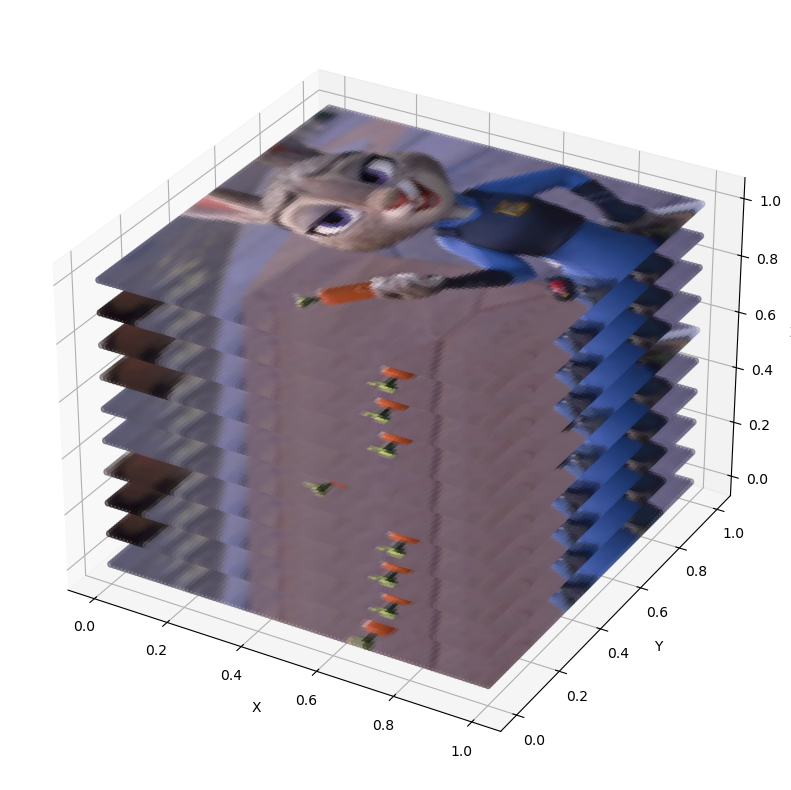

In [6]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.scatter3D(pts[:,0], pts[:,1], pts[:,2], c=Y)
ax.set_xlabel('X');ax.set_ylabel('Y');ax.set_zlabel('Z')

plt.show()

In [8]:
Y.shape

torch.Size([100000, 3])

## No Encodings

In [6]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x
    
model = Model(3).to(device)

opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()


In [7]:
results_folder = 'results/3d_xyz2color/'
os.makedirs(results_folder, exist_ok=True)

In [8]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)
for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()
    predictions = model(pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)

    losses+= [loss.item()]
    # for i in range(1000):
        

100%|██████████| 1000/1000 [00:22<00:00, 43.57it/s]


In [9]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the specified directory
os.chdir(results_folder)
# Define the ffmpeg command
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=100:250:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xyz2rgb_animation.gif
os.chdir('../..')


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 0.009635006077587605')

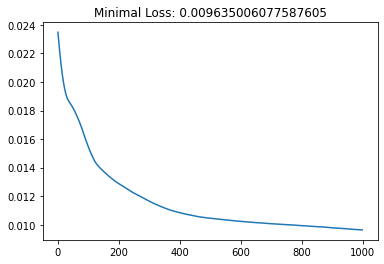

In [10]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

## Freq 3D encoding

In [11]:
class FreqEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

In [12]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


In [13]:
freq_encoder = FreqEncoder(
    d_input=3,
    n_freqs=3,
    log_space=False
)

test_x = freq_encoder(pts)
print(pts.shape, ' -> ', test_x.shape)
model = Model(test_x.shape[-1]).to(device)
print('Same number of dimations with hash encoding')

torch.Size([100000, 3])  ->  torch.Size([100000, 21])
Same number of dimations with hash encoding


In [14]:
# Optimim
opt = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [15]:
# Results logging folder
results_folder = 'results/3d_xyzFreq2color/'
os.makedirs(results_folder, exist_ok=True)

In [16]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    freq_pts = freq_encoder(pts)

    predictions = model(freq_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # LOGS
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    image = get_3d_image_height(predictions, RESOLUTION)
    image.save(ph)

    losses+= [loss.item()]
        

100%|██████████| 1000/1000 [00:25<00:00, 39.82it/s]


In [17]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the images directory
os.chdir(results_folder)
# Define the ffmpeg command

# General 
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=100:250,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xyzFreq2rgb_animation.gif
os.chdir('../..')

# If first one doesn't work 
# font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf'
# !ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=100:250,fps=48,drawtext=text='%{n}':fontfile=/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf':start_number=0:x=10:y=10:fontsize=24:fontcolor=white" ../xyzFreq2rgb_animation.gif
# os.chdir('../..')

# Compress gif with 
# gifsicle -i ani.gif --lossy=30 --colors 256 -o new_ani.gif

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 0.008843477815389633')

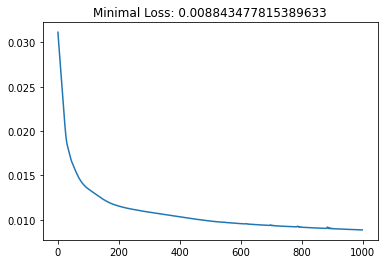

In [18]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

## Encoding 3D Multiresolution Hash

In [20]:
class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 device='cpu'
                 ):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        self.device = device

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights, weights, weights], -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


grid = Grid(
    feature_dim=3,
    grid_dim=3,
    num_lvl=6,
    max_res=1024*2+1024*2,
    min_res=16,
    hashtable_power=19,
    device=device,
).to(device)


In [21]:
class Model(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim,32)
        self.f2 = nn.Linear(32,32)
        self.f3 = nn.Linear(32,32)
        self.f4 = nn.Linear(32,3)
        self.act = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self,x):
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        x = self.f3(x)
        x = self.act(x)
        x = self.f4(x)
        x = self.s(x)
        return x


test_x = grid(pts.to(device))
print(test_x.shape)
model = Model(test_x.shape[-1]).to(device)

torch.Size([100000, 18])


In [27]:
test_x.min(0)[0], test_x.max(0)[0]

(tensor([-0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003,
         -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003, -0.0003,
         -0.0003, -0.0003], device='cuda:0', grad_fn=<MinBackward0>),
 tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
         0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
        device='cuda:0', grad_fn=<MaxBackward0>))

In [28]:
opt = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': grid.parameters()},
])

crit = nn.MSELoss()


In [29]:
results_folder = 'results/3d_xyzHash2color/'
os.makedirs(results_folder, exist_ok=True)

In [30]:
EPOCHS = 1000
losses = []
pts = pts.to(device)
Y = Y.to(device)

for epoch in tqdm(range(EPOCHS)):
    opt.zero_grad()

    enc_pts = grid(pts)

    predictions = model(enc_pts)

    loss = crit(predictions, Y)
    loss.backward()
    opt.step()

    # Logging
    ph = results_folder+'0'*(5-len(str(epoch)))+str(epoch)+'.png'
    pred_img = get_3d_image_height(predictions, RESOLUTION)
    pred_img.save(ph)
    losses+= [loss.item()]
        

100%|██████████| 1000/1000 [00:38<00:00, 26.00it/s]


In [24]:
# Make a gif
# You need to change scale if you will try to change output size

# Change to the Images directory
os.chdir(results_folder)
# Define the ffmpeg command
!ffmpeg -y -pattern_type glob -i "*.png" -vf "scale=100:250:-1,fps=48,drawtext=text='%{n}':start_number=0:x=10:y=10:fontsize=12:fontcolor=white" ../xyzHash2rgb_animation.gif
os.chdir('../..')


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Text(0.5, 1.0, 'Minimal Loss: 3.0715541470272e-06')

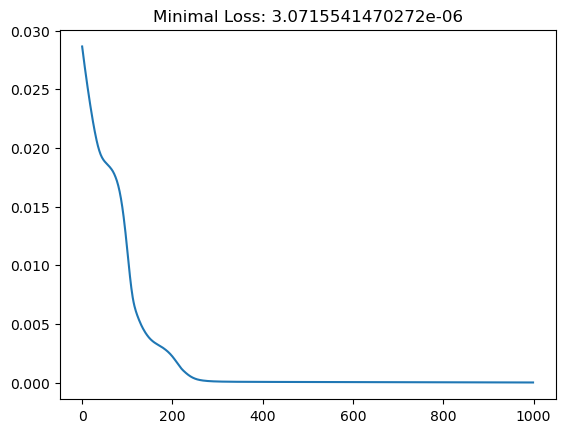

In [31]:
plt.plot(losses)
plt.title(f'Minimal Loss: {np.min(losses)}')

In [33]:
test_x = grid(pts.to(device))
print(test_x.shape)
test_x.min(0)[0], test_x.max(0)[0]

torch.Size([100000, 18])


(tensor([-0.2375, -0.2223, -0.3369, -0.2813, -0.3179, -0.3810, -0.3981, -0.3245,
         -0.2850, -0.3403, -0.2983, -0.2932, -0.4420, -0.3688, -0.4653, -0.3185,
         -0.3374, -0.3983], device='cuda:0', grad_fn=<MinBackward0>),
 tensor([0.2030, 0.3758, 0.3514, 0.3391, 0.4159, 0.3031, 0.2846, 0.3611, 0.4026,
         0.4179, 0.4128, 0.4706, 0.2818, 0.2978, 0.3125, 0.3201, 0.2583, 0.2570],
        device='cuda:0', grad_fn=<MaxBackward0>))

---